<a href="https://colab.research.google.com/github/jim8220/AutoSusPed/blob/main/practice_1/Introduction_to_Anomaly_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **EE 488 AI Convergence Capstone Design : Anomaly Detection**
## **practice 1-1 : Introduction to Anomaly Detection**
Anomaly detection can be done by various pretext tasks. In this session, we will do anomaly detection with reconstruction as a pretext task on the MNIST dataset. 💻

In [ ]:
import torch
from torch import nn
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, TensorDataset
from sklearn import metrics
import matplotlib.pyplot as plt
import torchsummary

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Using cuda device


In [ ]:

LATENT_DIM = 32
EPOCHS = 1000
BATCH = 32
ANOMALY_NUM = 9

In [ ]:
mnist_train = datasets.MNIST(root='MNIST_data/', train=True, transform=ToTensor(), download=True)
mnist_test = datasets.MNIST(root='MNIST_data/', train=False, transform=ToTensor(), download=True)

train_normal = [mnist_train[i][0].numpy() for i, v in enumerate(mnist_train) if v[1] != ANOMALY_NUM]

train_dataset = train_normal[:-int(len(train_normal) / 10)]
val_dataset = train_normal[-int(len(train_normal) / 10):]

train_dataset = torch.Tensor(train_dataset)
val_dataset = torch.Tensor(val_dataset)

test_x = torch.tensor([v[0].numpy() for v in mnist_test])
test_y = torch.tensor([0 if v[1] != ANOMALY_NUM else 1 for v in mnist_test])
test_dataset = TensorDataset(test_x, test_y)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  if __name__ == '__main__':


In [ ]:
# n = 500
# plt.figure(figsize=(n, 4))

# for i in range(n):
#   input_image = train_normal[i]
#   ax = plt.subplot(2, n/2, i + 1)
#   plt.imshow(input_image[0])
#   plt.gray()
#   ax.get_xaxis().set_visible(False)
#   ax.get_yaxis().set_visible(False)

# plt.show()

In [ ]:
class AutoEncoder(nn.Module):
    def __init__(self, encoding_dim):
        super(AutoEncoder, self).__init__()
        self.encoding_dim = encoding_dim
        self.encoder = nn.Sequential(
            nn.Linear(28*28, self.encoding_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(self.encoding_dim, 784),
            nn.Sigmoid()
        )

    def forward(self, x):
        out = x.reshape(x.size(0), -1)
        out = self.encoder(out)
        out = self.decoder(out)
        out = out.view(x.size())
        return out

In [ ]:
class ConvAutoEncoder(nn.Module):
    def __init__(self):
        super(ConvAutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 2, kernel_size=(3, 3), stride=(2, 2), padding=1),
            nn.ReLU(),
            nn.Conv2d(2, 4, kernel_size=(3, 3), stride=(2, 2), padding=1),
            nn.ReLU(),
            nn.Conv2d(4, 8, kernel_size=(3, 3), stride=(2, 2), padding=1),
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=1),
            nn.ReLU(),
            nn.Flatten())
        self.linear = nn.Sequential(
            nn.Linear(64, 8),
            nn.ReLU(),
            nn.Linear(8,8),
            nn.ReLU(),
            nn.Linear(8,8),
            nn.ReLU(),
            nn.Linear(8, 64),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1)),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1)),
            nn.ReLU(),
            nn.ConvTranspose2d(4, 2, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1)),
            nn.ReLU(),
            nn.Conv2d(2, 1, kernel_size=(3, 3), padding=(1, 1)),
            nn.Sigmoid(),
        )

    def forward(self, x):
        output = self.linear(self.encoder(x))
        output = output.view(-1, 16, 2, 2)
        output = self.decoder(output)
        return output

In [ ]:
model = ConvAutoEncoder().to(device)
print(model)

ConvAutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(1, 2, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(2, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(4, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
    (8): Flatten(start_dim=1, end_dim=-1)
  )
  (linear): Sequential(
    (0): Linear(in_features=64, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=8, bias=True)
    (5): ReLU()
    (6): Linear(in_features=8, out_features=64, bias=True)
    (7): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)

In [ ]:
loss_fn = nn.MSELoss()
anomaly_score = nn.MSELoss(reduction='none')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,20)

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, X in enumerate(dataloader):
        X = X.to(device)

        pred = model(X)
        loss = loss_fn(pred, X)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 300 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [ ]:
def test(dataloader, model, anomaly_score):
    model.eval()

    y_true, y_pred = [], []

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            output = model(X)
            score = torch.mean(anomaly_score(X, output), (1, 2, 3))

            y_true.extend(y.tolist())
            y_pred.extend(score.tolist())

    roc_auc = metrics.roc_auc_score(y_true, y_pred)
    print(f'AUC: {roc_auc:>0.3f}')


In [ ]:
for t in range(EPOCHS):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, anomaly_score)


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
loss: 0.024353  [19200/48646]
loss: 0.025528  [28800/48646]
loss: 0.028640  [38400/48646]
loss: 0.020036  [48000/48646]
AUC: 0.679
Epoch 446
-------------------------------
loss: 0.022589  [    0/48646]
loss: 0.024732  [ 9600/48646]
loss: 0.024416  [19200/48646]
loss: 0.025304  [28800/48646]
loss: 0.028572  [38400/48646]
loss: 0.020013  [48000/48646]
AUC: 0.680
Epoch 447
-------------------------------
loss: 0.022655  [    0/48646]
loss: 0.024618  [ 9600/48646]
loss: 0.024403  [19200/48646]
loss: 0.025331  [28800/48646]
loss: 0.028593  [38400/48646]
loss: 0.019882  [48000/48646]
AUC: 0.677
Epoch 448
-------------------------------
loss: 0.022697  [    0/48646]
loss: 0.024693  [ 9600/48646]
loss: 0.024551  [19200/48646]
loss: 0.025330  [28800/48646]
loss: 0.028529  [38400/48646]
loss: 0.019967  [48000/48646]
AUC: 0.679
Epoch 449
-------------------------------
loss: 0.022667  [    0/48646]
loss: 0.024673  [ 9600/48646]
loss: 0.024402  [19200/48646]
lo

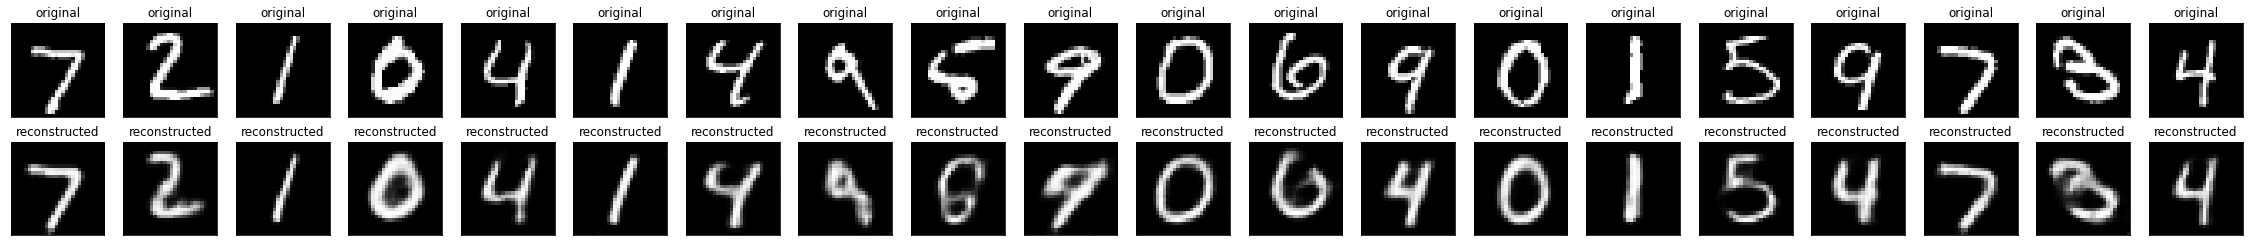

In [ ]:
n = 20
plt.figure(figsize=(2*n, 4))

for i in range(n):
  input_image = test_dataset[i][0].to(device)
  output_image = model(input_image.unsqueeze(0))

  ax = plt.subplot(2, n, i + 1)
  plt.imshow(input_image[0].cpu())
  plt.title('original')
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(output_image[0].squeeze().detach().cpu())
  plt.title('reconstructed')
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

plt.show()